#  Прогнозирование заказов такси

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Prophet" data-toc-modified-id="Prophet-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Prophet</a></span></li><li><span><a href="#SARIMAX" data-toc-modified-id="SARIMAX-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>SARIMAX</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

Импортируем библиотеки.

In [1]:
!pip install --user --upgrade scikit-learn -q

In [2]:
!pip install pmdarima -q

In [3]:
!pip install prophet -q

In [4]:
!pip install skforecast -q

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import time
import lightgbm as  lgb
import statsmodels
import skforecast

from matplotlib import rcParams
from scipy import stats as st
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression
)

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
)
    
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import TimeSeriesSplit

from pmdarima import auto_arima
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from skforecast.recursive import ForecasterSarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_sarimax


Загружаем данные.

In [6]:
pth1 = '/datasets/taxi.csv'
pth2 = 'https://code.s3.yandex.net/datasets/taxi.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
else:
    print('Something is wrong')

Проверяем корректность загрузки.

In [7]:
display(data.head())

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Выводим общую информацию о датафрейме.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Проверим на дубликаты.

In [9]:
data.duplicated().sum()

0

Дубликатов нет.

Переведем столбец 'datetime' в формат времени datetime.

In [10]:
data['datetime']=pd.to_datetime(data['datetime'])

Установим индекс таблицы равным столбцу datetime и отсортируем по возрастанию.

In [11]:
data = data.set_index(data.datetime)
data.sort_index(inplace=True)

Выполним ресемплирование по одному часу.

In [12]:
data = data.resample('h', on='datetime').sum()

Проверим корректность ресемплирования.

In [13]:
display(data.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Таким образом данные загружены корректно и готовы к работе.

## Анализ

Построим график временного ряда.

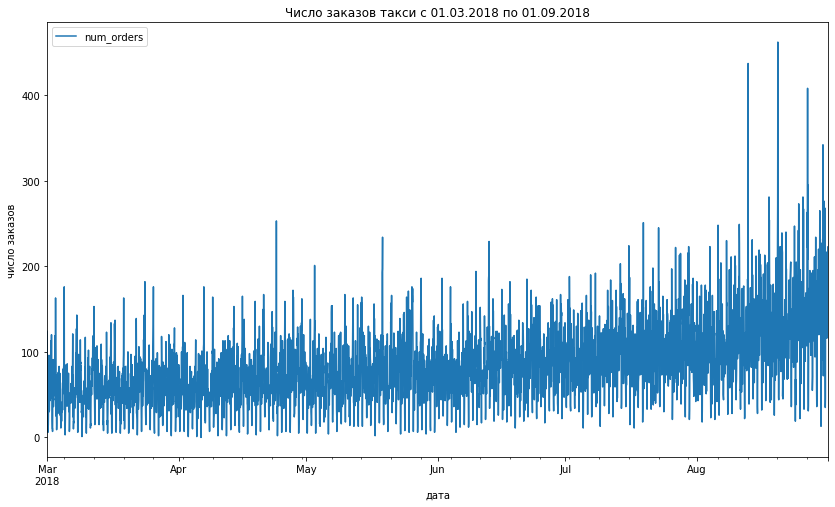

In [14]:
data.plot(figsize=(14,8))

plt.title('Число заказов такси с 01.03.2018 по 01.09.2018') 
plt.xlabel('дата') 
plt.ylabel('число заказов')
plt.show() 

Слишком много значений, все они сливаются так, что трудно разглядеть график. 

Построим график на небольшом временном промежутке - на одной неделе, и добавим туда еще скользящее среднее числа заказов за 24 часа.

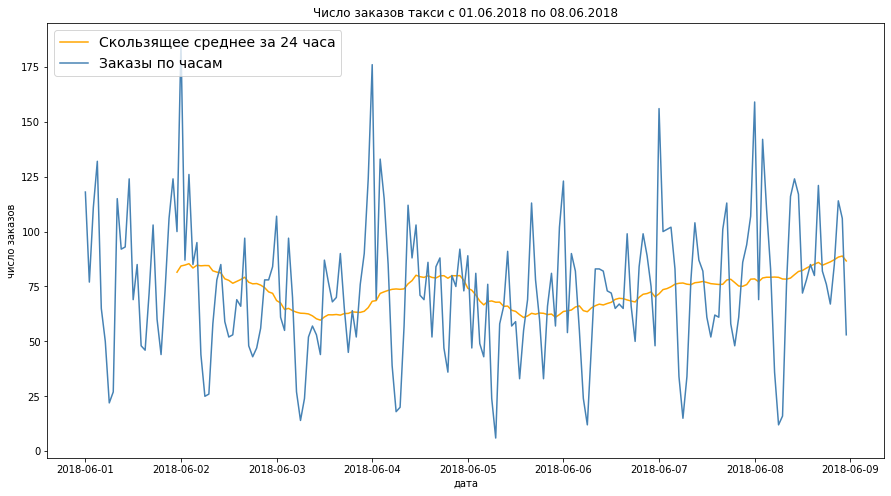

In [15]:
data_tmp = data['2018-06-01':'2018-06-08']

plt.figure(figsize = (15,8))
plt.plot(data_tmp.rolling(window = 24).mean(), label = 'Скользящее среднее за 24 часа', color = 'orange')
plt.plot(data_tmp, label = 'Заказы по часам', color = 'steelblue')

plt.legend(title = '', loc = 'upper left', fontsize = 14)
plt.title('Число заказов такси с 01.06.2018 по 08.06.2018') 
plt.xlabel('дата') 
plt.ylabel('число заказов')
plt.show() 

На этом графике видны четкие всплески числа заказов в начале суток и такие же четкие падения после этих пиков - видимо, ночные часы, затем в течение дня происходит еще несколько меньших всплесков и падений.

Разложим временной ряд на тренд и сезонную компоненту.

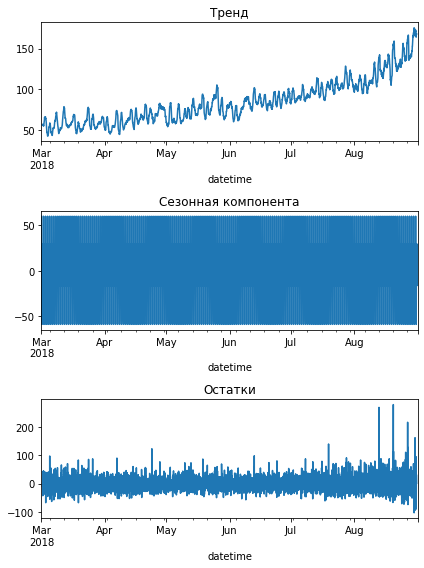

In [16]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонная компонента')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

Опять на графиках сложно что-либо разглядеть, построим тренд, сезонную компоненту и остатки на двухнедельном периоде. 

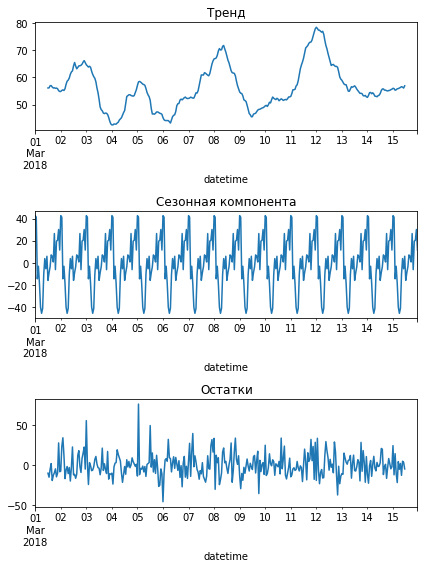

In [17]:
decomposed = seasonal_decompose(data['2018-03-01':'2018-03-15'])

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонная компонента')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()


Здесь уже видно, что ряд имеет  четко выраженную сезонную компоненту - одни сутки.

Построим  еще график автокорреляционной функции для лагов от 0 до 100, чтобы убедиться в наличии сильной сезонной компоненты. 

<Figure size 1080x576 with 0 Axes>

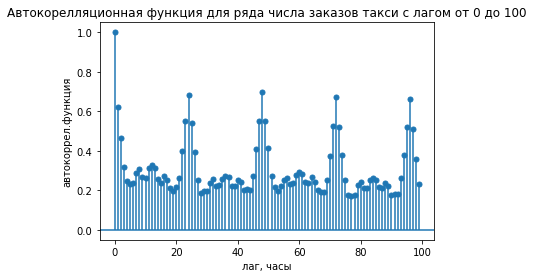

In [18]:
plt.figure(figsize = (15,8))

plot_acf(data, lags = np.arange(100), alpha = None) 

plt.title('Автокорелляционная функция для ряда числа заказов такси с лагом от 0 до 100') 
plt.xlabel('лаг, часы') 
plt.ylabel('автокоррел.функция')
 
plt.axis('tight')
plt.show()

По этому графику тоже заметно, что значения ряда с лагом 24 часа сильно коррелируют друг с другом, что говорит о сезонности длительностью 24 часа.

Оценим  формально стационарность нашего ряда. Для этого применим тест Дики-Фуллера.

Нулевая гипотеза: процесс нестационарный;

альтернативная гипотеза: процесс стационарный.

Уровень значимости примем 0.05.

In [19]:
adf_test = adfuller(data['num_orders'])

print('p-value = ' + str(adf_test[1]))

p-value = 0.028940051402612906


p-value меньше 0.05, отвергаем нулевую гипотезу, временной ряд стационарен.

Хотя из первого графика явно прослеживается тренд на увеличение заказов от марта к сентябрю, что не согласуется со стационарностью.

## Обучение

### Линейная регрессия

Напишем функцию для создания новых признаков:

- добавления часа, дня, месяца и дня недели,

- столбцов с предыдущими значениями с лагом от 1 до max_lag,

- столбца со значением скользящего среднего с шириной окна rolling_mean_size.

In [20]:
def make_features(data, max_lag,rolling_mean_size):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['month'] = data.index.month
    data['dayofweek'] = data.index.dayofweek
    for i in range(max_lag):
        data['lag_'+str(i+1)] = data['num_orders'].shift(i+1)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Сделаем копию исходного датафрейма.

In [21]:
data_copy=data.copy()

В цикле переберем значения лагов от 1 до 30 и ширину окна от 1 до 30, для каждой пары значений создадим набор признаков с помощью функции make_features, создадим тренировочную, валидационную и тестовую выборку и обучим модель линейной регрессии на обучающей выборке.

На каждом шаге будем запоминать число лагов, ширину окна и метрику RSME, посчитанную на валидационной выборке.

Затем выберем модель с наименьшой метрикой на валидационной выборке.

In [22]:
# списки для числа лагов, ширины окна и метрики RSME
x=[]
y=[]
p_best=[]

In [23]:
for i in range(1,30):
    for j in range(1,30):
        data=data_copy.copy()
        make_features(data, i, j)
      
        train_val, test = train_test_split(data, shuffle=False, test_size=0.1)

        train, train_val= train_test_split(train_val, shuffle=False, test_size=0.1)

        train=train.dropna()

        X_train = train.drop(columns='num_orders')
        y_train = train.num_orders

        X_val=train_val.drop(columns='num_orders')
        y_val=train_val.num_orders

        X_test = test.drop(columns='num_orders')
        y_test = test.num_orders

        model = LinearRegression()
        model.fit(X_train,y_train)

        p=model.predict(X_val)

        x.append(i)
        y.append(j)
        p_best.append(root_mean_squared_error(y_val, p))

Объединим списки для числа лагов, ширины окна и метрики RSME в один датафрейм.

In [24]:
dt = {
    'x': x,
    'y': y,
    'p_best':p_best
}
df = pd.DataFrame(dt)
display(df.head())

,x,y,p_best
0,1,1,41.131911
1,1,2,41.228886
2,1,3,41.147950
3,1,4,41.009517
4,1,5,40.926280


Отберем записи с наименьшей метрикой.

In [25]:
df1=df[df['p_best']==df['p_best'].min()]
display(df1)
rsme_regression=df['p_best'].min()

,x,y,p_best
722,25,27,34.164517


После выбора наилучших параметров с помощью проверочного набора - валидационной выборки, мы можем заново построить модель, используя найденные настройки, но теперь на основе объединенных обучающих и проверочных данных - train_val_all.

Возвращаемся к исходному датафрейму и добавляем 25 признаков с лагами и один с окном шириной 27.

In [26]:
data=data_copy.copy()
display(data.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [27]:
make_features(data,25, 27)

Выделяем тренировочную, валидационную и тестовую выборки, а также выборку, которая объединяет тренировочную и валидационную.

In [28]:
train_val_all, test = train_test_split(data, shuffle=False, test_size=0.1)
train, train_val= train_test_split(train_val_all, shuffle=False, test_size=0.1)
train=train.dropna()
train_val_all=train_val_all.dropna()

X_train = train.drop(columns='num_orders')
y_train = train.num_orders

X_val=train_val.drop(columns='num_orders')
y_val=train_val.num_orders

X_train_and_val=train_val_all.drop(columns='num_orders')
y_train_and_val=train_val_all.num_orders

X_test = test.drop(columns='num_orders')
y_test = test.num_orders

Отметим даты, которые попали в тренировочную, валидационную и тестовую выборку.

In [29]:
print(train.index.min(), train.index.max())
print(train_val.index.min(), train_val.index.max())
print(train_val_all.index.min(),train_val_all.index.max())
print(test.index.min(), test.index.max())

2018-03-02 03:00:00 2018-07-27 23:00:00
2018-07-28 00:00:00 2018-08-13 13:00:00
2018-03-02 03:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Обучаем модель на объединенной тренировочной и валидационной выборке, считаем RMSE валидационной выборки.

In [30]:
model_lr = LinearRegression()
model_lr.fit(X_train_and_val,y_train_and_val)

pred_val=model_lr.predict(X_val)

print("RMSE валидационной выборки:", root_mean_squared_error(y_val, pred_val))

RMSE валидационной выборки: 33.82287234773329


Полученное значение будем сравнивать с RMSE валидационной выборки других моделей.

Можно построить график исходных значений и предсказаний на валидационной выборке.

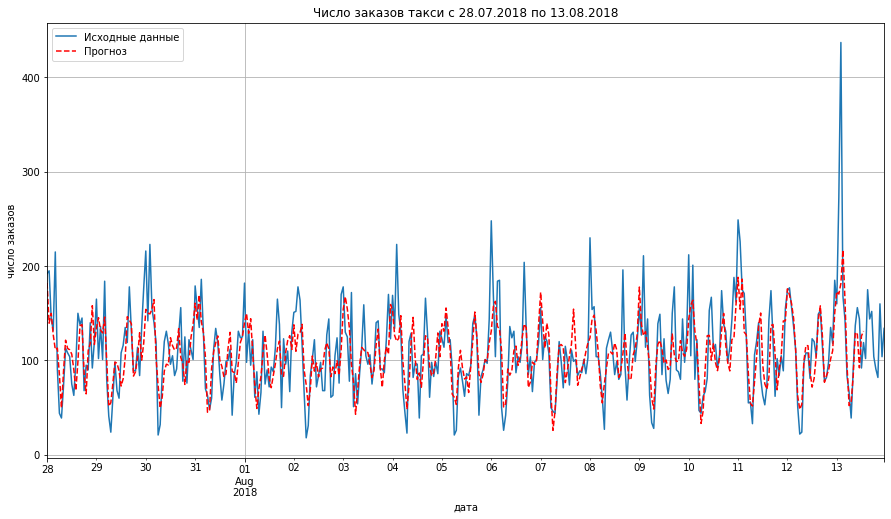

In [31]:
plt.figure(figsize = (15,8))

data['2018-07-28':'2018-08-13'].num_orders.plot()
_ = pd.Series(index=X_val.index, data=pred_val).plot(c='red', style='--')
_ = plt.legend(['Исходные данные', 'Прогноз' ])

plt.grid()
plt.title('Число заказов такси с 28.07.2018 по 13.08.2018') 
plt.xlabel('дата') 
plt.ylabel('число заказов')
plt.show()

Как видим, наша модель в целом неплохо предсказывает число заказов.

Можно еще посмотреть, какие признаки внесли наибольший вес в нашу модель.

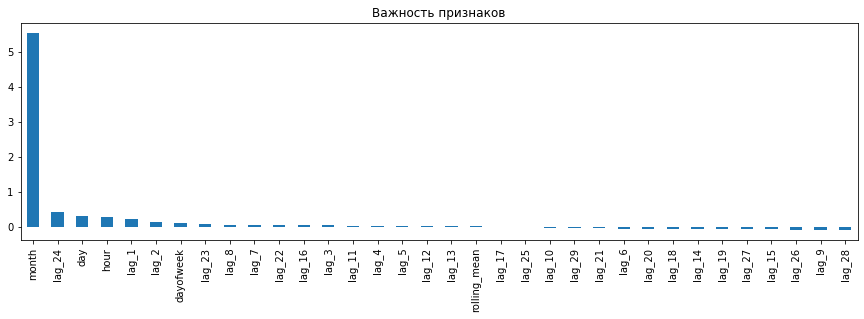

In [32]:
plt.figure(figsize = (15,4))

_ = pd.Series(model.coef_, index=model.feature_names_in_).sort_values(ascending=False).plot(kind='bar')

plt.title('Важность признаков') 

plt.show()

Месяц внес самый большой вес в модель по сравнению со всеми остальными признаками. Лаг размером 24 часа, как ни странно, внес гораздо меньший вклад.

### Prophet

Используем модель Prophet для построения прогноза нашего ряда.

Возьмем исходник нашего датафрейма, сбросим индексы и переименуем столбцы в соответствии с требованиями модели.

In [33]:
df_prophet = data_copy.copy()
df_prophet.reset_index(inplace=True)

In [34]:
df_prophet.columns = ['ds','y']
df_prophet.head()

,ds,y
0,2018-03-01 00:00:00,124
1,2018-03-01 01:00:00,85
2,2018-03-01 02:00:00,71
3,2018-03-01 03:00:00,66
4,2018-03-01 04:00:00,43


Выделяем тренировочную, валидационную и тестовую выборки (здесь у нас не будет дополнительных признаков, выборки будут другие).

In [35]:
train_val, test = train_test_split(df_prophet, shuffle=False, test_size=0.1)

train, train_val= train_test_split(train_val, shuffle=False, test_size=0.1)

train=train.dropna()

In [36]:
print(train.index.min(), train.index.max())
print(train_val.index.min(), train_val.index.max())
print(test.index.min(), test.index.max())

0 3575
3576 3973
3974 4415


Задаем и обучаем модель Prophet.

In [37]:
model_prophet = Prophet()
model_prophet.fit(train)

10:47:12 - cmdstanpy - INFO - Chain [1] start processing
10:47:12 - cmdstanpy - INFO - Chain [1] done processing


Получаем прогноз на валидационной выборке с помощью встроенной функции make_future_dataframe.

Частоту временных рядов указываем час, число периодов пусть совпадает с размером валидационной выборки.

In [38]:
future = model_prophet.make_future_dataframe(periods=train_val.shape[0], freq='H')

/opt/conda/lib/python3.9/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


Прогнозные значения помещаются в таблицу:

ds: временная метка прогнозируемого значения,

yhat: прогнозируемое значение метрики (в статистике обозначение yhat традиционно используется для представления прогнозируемых значений y),

yhat_lower: нижняя граница прогнозов,

yhat_upper: высшая граница прогнозов.

In [39]:
forecast = model_prophet.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3969,2018-08-13 09:00:00,114.648061,96.972459,154.131773,114.270674,115.032246,11.754490,11.754490,11.754490,4.236688,4.236688,4.236688,7.517802,7.517802,7.517802,0.0,0.0,0.0,126.402551
3970,2018-08-13 10:00:00,114.670832,101.759349,164.351640,114.291773,115.057373,17.376536,17.376536,17.376536,10.320919,10.320919,10.320919,7.055617,7.055617,7.055617,0.0,0.0,0.0,132.047368
3971,2018-08-13 11:00:00,114.693603,91.659937,149.976467,114.312872,115.082501,6.300998,6.300998,6.300998,-0.194037,-0.194037,-0.194037,6.495036,6.495036,6.495036,0.0,0.0,0.0,120.994601
3972,2018-08-13 12:00:00,114.716373,75.640292,136.881865,114.334880,115.107628,-8.053843,-8.053843,-8.053843,-13.895898,-13.895898,-13.895898,5.842055,5.842055,5.842055,0.0,0.0,0.0,106.662530
3973,2018-08-13 13:00:00,114.739144,75.005413,133.844665,114.357421,115.131716,-11.157450,-11.157450,-11.157450,-16.261216,-16.261216,-16.261216,5.103765,5.103765,5.103765,0.0,0.0,0.0,103.581694


Построим графики исходных данных и прогнозных на периоде валидационной выборки.

<Figure size 1080x576 with 0 Axes>

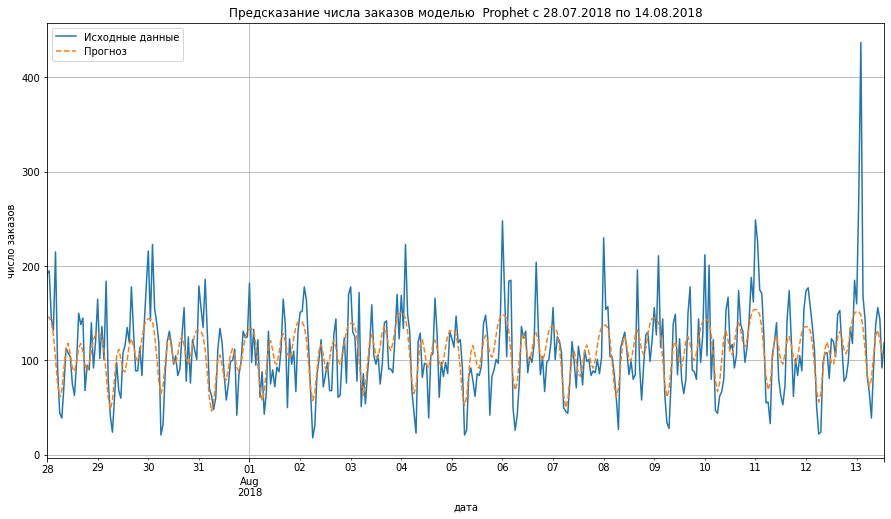

In [40]:
plt.figure(figsize = (15,8))

tmp_forecast = forecast[['ds', 'yhat']].set_index('ds', drop=True)
tmp_X_val = train_val.set_index('ds', drop=True)

ax=tmp_X_val['2018-07-28':'2018-08-14'].plot(label='Исходные данные', figsize = (15,8))
tmp_forecast['2018-07-28':'2018-08-14'].plot(label='Прогноз', ax=ax,style='--',figsize = (15,8))

_ = plt.legend(['Исходные данные','Прогноз'])

plt.grid()
plt.title('Предсказание числа заказов моделью  Prophet с 28.07.2018 по 14.08.2018') 
plt.xlabel('дата') 
plt.ylabel('число заказов')

plt.show()

На вид построенная модель сильно уменьшает пики, хотя в целом сезонность она угадывает верно.

Посчитаем RMSE на валидационной выборке.

In [41]:
preds_val = forecast.iloc[:train_val.shape[0]].yhat

root_mean_squared_error(train_val.y, preds_val)

64.63557487365806

Получилось много больше, чем у модели линейной регрессии.

Эту модель отвергаем.

### SARIMAX

Для пользования моделью SARIMAX необходимо настроить параметры на тренировочной выборке.



В качестве параметров SARIMAX возьмем (1,0,0)x(2,1,0,24).

Снова создаем тренировочную, валидационную и тестовую выборку, потому что формально у нас снова другой датафрейм. 

In [43]:
data=data_copy.copy()

train_val_all, test = train_test_split(data, shuffle=False, test_size=0.1)

train, train_val= train_test_split(train_val_all, shuffle=False, test_size=0.1)

train=train.dropna()

Создаем модель с подобранными параметрами и обучаем ее на тренировочной выборке.

In [44]:
model = SARIMAX(train,
                order = (1, 0, 0),
                seasonal_order = (2, 1, 0, 24))

# применим метод fit
result = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.59197D+00    |proj g|=  2.96276D-02

At iterate    5    f=  4.57975D+00    |proj g|=  9.20615D-02

At iterate   10    f=  4.54612D+00    |proj g|=  2.18776D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   1.300D-05   4.546D+00
  F =   4.5461126736499180     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


Создаем предсказания на валидационной выборке и считаем метрику RSME между предсказаниями и истинными значениями.

In [45]:
start = len(train)
 
end = len(train) + len(train_val) - 1
  
predictions = result.predict(start, end)

print(root_mean_squared_error(train_val, predictions))

34.598281788216134


Это значение чуть больше 33.8, которое получилось у линейной регрессии.

Посмотрим на графике предсказание на валидационной выборке.

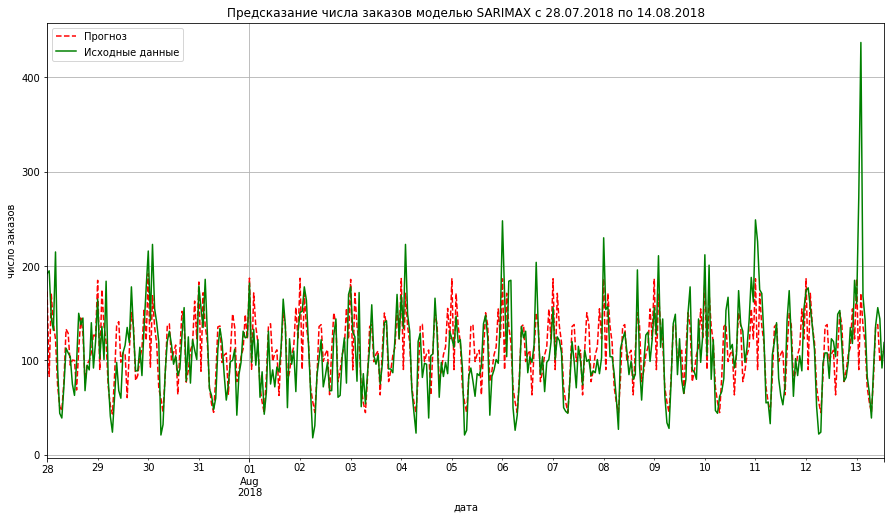

In [46]:
ax=predictions['2018-07-28':'2018-08-14'].plot(label='Прогноз', style='--',figsize = (15,8),color = "red")
train_val['2018-07-28':'2018-08-14'].plot(label='Исходные данные',ax=ax, figsize = (15,8),color ="green" )

plt.title('Предсказание числа заказов моделью SARIMAX с 28.07.2018 по 14.08.2018') 
plt.ylabel('число заказов')
plt.xlabel('дата')
_ = plt.legend(['Прогноз','Исходные данные',])
 
plt.grid() 
plt.show()

В целом, периодичность угадана верно, но амплитуда пиков явно занижена, как и у Prophet.

Формально, эту модель мы должны отвергнуть из-за значения RSME на валидационной выборке.

### DecisionTreeRegressor

Для прогнозирования временного ряда можно еще использовать DecisionTreeRegressor, только в исходные данные нужно добавить хотя бы один признак.

Можем организовать перебор числа лагов и ширины окна, как в пункте 3.1, чтобы определить такое число признаков, при котором DecisionTreeRegressor с параметрами по умолчанию будет давать наименьшую метрику на валидационной выборке.

In [47]:
#списки для хранения числа лагов, ширины окна и метрики на валидационной выборке
x=[]
y=[]
p_best=[]

In [48]:
for i in range(1,30):
    for j in range(1,30):

        data=data_copy.copy()
        make_features(data, i, j)
      
       
        train_val_all, test = train_test_split(data, shuffle=False, test_size=0.1)
        train, train_val= train_test_split(train_val_all, shuffle=False, test_size=0.1)
        train=train.dropna()
 
        X_train = train.drop(columns='num_orders')
        y_train = train.num_orders

        X_val=train_val.drop(columns='num_orders')
        y_val=train_val.num_orders

        model = DecisionTreeRegressor(random_state=42)
        model.fit(X_train,y_train)

        p=model.predict(X_val)
        x.append(i)
        y.append(j)
        p_best.append(root_mean_squared_error(y_val, p))

In [49]:
dt = {
    'x': x,
    'y': y,
    'p_best':p_best
}
df = pd.DataFrame(dt)

Выведем наилучшие параметры.

In [50]:
df1=df[df['p_best']>0]
df1=df1[df1['p_best']==df1['p_best'].min()]
display(df1)

,x,y,p_best
423,15,18,35.867463


Теперь добавим в модель 15 признаков с лагами, скользящее среднее с шириной 18, и обучим модель DecisionTreeRegressor на тренировочной + валидационной выборке, затем построим прогноз на валидационной выборке и посчитаем RSME.

In [51]:
data=data_copy.copy()
make_features(data, 15, 18)

train_val_all, test = train_test_split(data, shuffle=False, test_size=0.1)
train, train_val= train_test_split(train_val_all, shuffle=False, test_size=0.1)
train=train.dropna()

X_train = train.drop(columns='num_orders')
y_train = train.num_orders

X_val=train_val.drop(columns='num_orders')
y_val=train_val.num_orders

X_train_and_val=train_val_all.drop(columns='num_orders')
y_train_and_val=train_val_all.num_orders

X_test = test.drop(columns='num_orders')
y_test = test.num_orders

model = DecisionTreeRegressor(random_state=42)
model.fit(X_train_and_val,y_train_and_val)

p=model.predict(X_val)
root_mean_squared_error(y_val, p)

0.0

На валидационной выборке модель выдала метрику 0, видимо дерево переобучилось.

Можно посмотреть на графике.

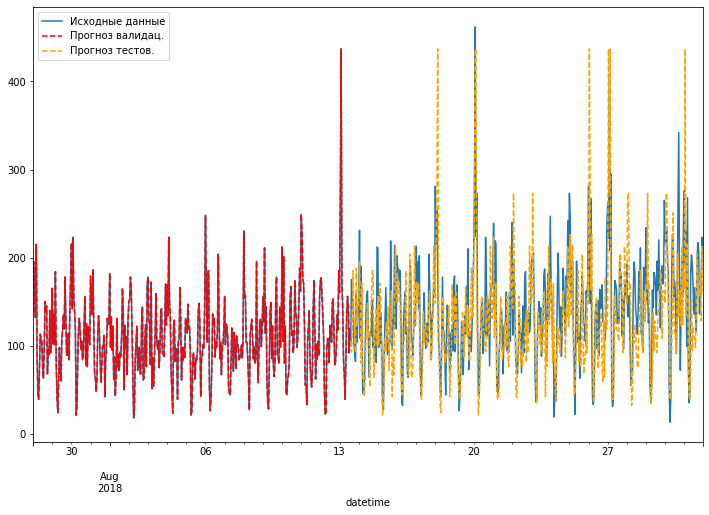

In [52]:
pred = model.predict(X_val)
pred_test=model.predict(X_test)
data['2018-07-28':'2018-08-31'].num_orders.plot(figsize=(12,8))
_ = pd.Series(index=X_val.index, data=pred).plot(c='red', style='--',figsize=(12,8))
_ = pd.Series(index=X_test.index, data=pred_test).plot(c='orange', style='--',figsize=(12,8))
_ = plt.legend(['Исходные данные', 'Прогноз валидац.','Прогноз тестов.' ])

Действительно, на валидационном отрезке видно полное совпадение прогноза и исходных данных, а на тестовом уже отличия есть. 

Можно попробовать подобрать гиперпараметры для дерева с помощью GridSearchCV и кросс-валидацией для временных рядов с помощью TimeSeriesSplit (признаки оставим те же).

In [54]:
cv = TimeSeriesSplit(n_splits=9)

params = {'max_depth':[100,200],
          'min_samples_leaf': range(1, 6),
          'min_samples_split': range(2, 6)
      
         }

model = GridSearchCV(
    DecisionTreeRegressor(random_state=42), 
    param_grid=params, 
    cv=cv,
    scoring='neg_root_mean_squared_error'
)

model.fit(X_train,y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=9, test_size=None),
             estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [100, 200],
                         'min_samples_leaf': range(1, 6),
                         'min_samples_split': range(2, 6)},
             scoring='neg_root_mean_squared_error')

In [55]:
model.best_params_

{'max_depth': 100, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [56]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(model.cv_results_)
display(result[
    ['rank_test_score',  'mean_test_score','params']
].sort_values('rank_test_score')) 


,rank_test_score,mean_test_score,params
19,1,-28.478685,"{'max_depth': 100, 'min_samples_leaf': 5, 'min_samples_split': 5}"
37,1,-28.478685,"{'max_depth': 200, 'min_samples_leaf': 5, 'min_samples_split': 3}"
36,1,-28.478685,"{'max_depth': 200, 'min_samples_leaf': 5, 'min_samples_split': 2}"
38,1,-28.478685,"{'max_depth': 200, 'min_samples_leaf': 5, 'min_samples_split': 4}"
18,1,-28.478685,"{'max_depth': 100, 'min_samples_leaf': 5, 'min_samples_split': 4}"
17,1,-28.478685,"{'max_depth': 100, 'min_samples_leaf': 5, 'min_samples_split': 3}"
16,1,-28.478685,"{'max_depth': 100, 'min_samples_leaf': 5, 'min_samples_split': 2}"
39,1,-28.478685,"{'max_depth': 200, 'min_samples_leaf': 5, 'min_samples_split': 5}"
35,9,-29.054199,"{'max_depth': 200, 'min_samples_leaf': 4, 'min_samples_split': 5}"
32,9,-29.054199,"{'max_depth': 200, 'min_samples_leaf': 4, 'min_samples_split': 2}"


Лучшая метрика 28.47 меньше, чем у линейной регрессии.

Построим снова график исходных данных и прогноза.

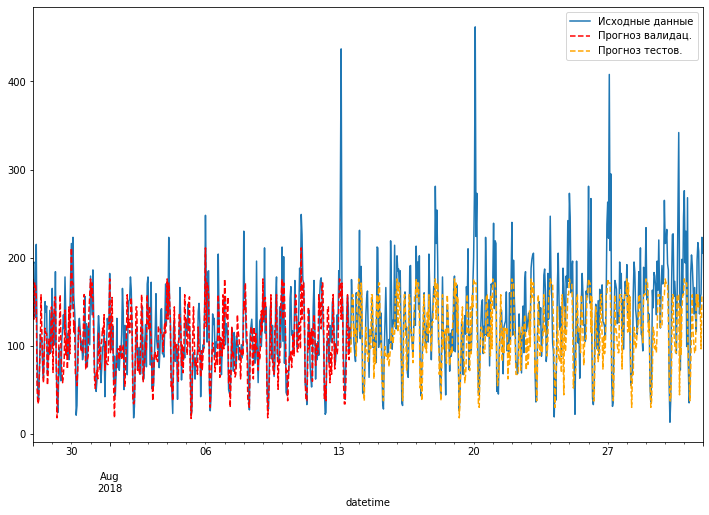

In [57]:
pred = model.predict(X_val)
pred_test=model.predict(X_test)
data['2018-07-28':'2018-08-31'].num_orders.plot(figsize=(12,8))
_ = pd.Series(index=X_val.index, data=pred).plot(c='red', style='--',figsize=(12,8))
_ = pd.Series(index=X_test.index, data=pred_test).plot(c='orange', style='--',figsize=(12,8))
_ = plt.legend(['Исходные данные', 'Прогноз валидац.','Прогноз тестов.' ])

Для этой лучшей модели уже отличаются исходные данные от прогноза на валидационной выборке, и на тестовой они отличаются еще больше.

## Тестирование

Итак, формально лучшей моделью стала  DecisionTreeRegressor, посчитаем RMSE тестовой выборки.

In [58]:
pred=model.predict(X_test)

print("RMSE тестовой выборки:", root_mean_squared_error(y_test, pred))

RMSE тестовой выборки: 49.848878267995566


Это значение выше требуемого, поэтому возвращаемся к модели линейной регрессии, и считаем RSME на тестовой выборке для нее (только тестовую выборку придется создать снова, потому что число признаков в моделях отличается).

In [59]:
data=data_copy.copy()
make_features(data,25, 27)
train_val_all, test = train_test_split(data, shuffle=False, test_size=0.1)
train, train_val= train_test_split(train_val_all, shuffle=False, test_size=0.1)
train=train.dropna()
train_val_all=train_val_all.dropna()

X_train = train.drop(columns='num_orders')
y_train = train.num_orders

X_val=train_val.drop(columns='num_orders')
y_val=train_val.num_orders

X_train_and_val=train_val_all.drop(columns='num_orders')
y_train_and_val=train_val_all.num_orders

X_test = test.drop(columns='num_orders')
y_test = test.num_orders

In [60]:
pred=model_lr.predict(X_test)

print("RMSE тестовой выборки:", root_mean_squared_error(y_test, pred))

RMSE тестовой выборки: 46.19456546269059


Это значение удовлетворяет требованиям. 

Можно еще построить график исходных данных и прогноза на валидационной и тестовой выборке.

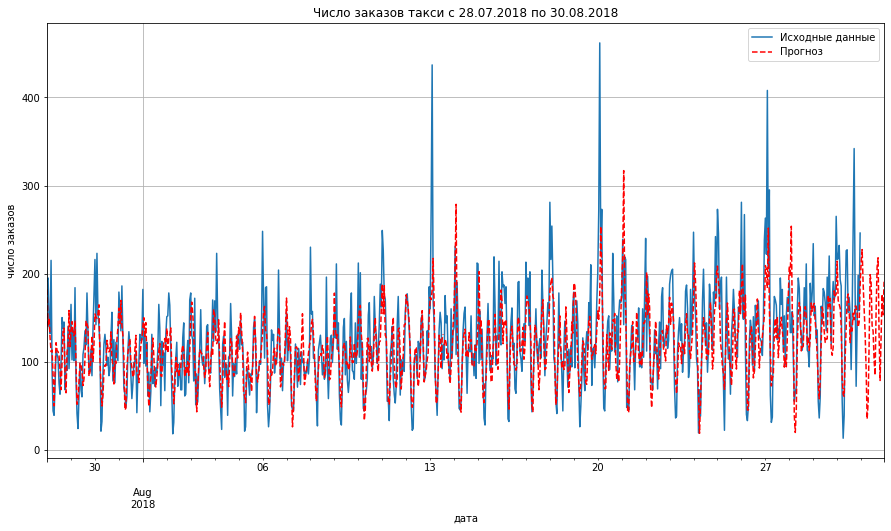

In [61]:
plt.figure(figsize = (15,8))

data['2018-07-28':'2018-08-30'].num_orders.plot()
_ = pd.Series(index=X_val.index, data=pred_val).plot(c='red', style='--')
_= pd.Series(index=X_test.index, data=pred).plot(c='red', style='--')
_ = plt.legend(['Исходные данные', 'Прогноз' ])

plt.grid()
plt.title('Число заказов такси с 28.07.2018 по 30.08.2018') 
plt.xlabel('дата') 
plt.ylabel('число заказов')
plt.show()

Итого:

Линейная регресия не только аккуратно подобрала шаг периодичности, но и лучше справилась с амплитудой пиков, хотя в целом она  их занижает, но не так сильно, как остальные рассмотренные модели.

Поэтому линейная регрессия (с добавлением дополнительных признаков в модель) показала наилучший результат в задаче прогноза числа заказов.